In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from astropy.table import Table, vstack, join
from Ska.Matplotlib import plot_cxctime
import cPickle
from Ska.engarchive import fetch
from kadi import events
from Chandra.Time import DateTime
from Ska.Numpy import interpolate
import os
from itertools import izip
import resid_shared

Read in sources from table file

In [3]:
srcs = Table.read('src_table.dat', format='ascii')
used = (srcs['point_source'] == 'True')
srcs = srcs[used]

In [4]:
resid_obsids = srcs[(srcs['kalman_tstop'] - srcs['kalman_tstart']) > 10000]['obsid']
BIN = 10000.
DATADIR = 'auto'
AX = 'yag'
resid_shared.DATADIR = DATADIR
resid_shared.BIN = BIN

In [5]:
GRADIENTS = dict(OOBAGRD3=dict(yag=6.98145650e-04,
                                zag=9.51578351e-05),
                OOBAGRD6=dict(yag=-1.67009240e-03,
                                zag=-2.79084775e-03))

In [6]:
def tilt_model(tilt):
    """
    Define a model for the periscope based on three MSIDS.  The tilt telemetry should be passed
    as columns in an astropy Table.  
    The MSIDs were already interpolated when the binned MSIDs were made in the standard use of 
    calling this on data from get_all_bins().
    Returns model function.
    """
    ax = tilt['oobagrd3'].data
    di = tilt['oobagrd6'].data
    ax_mean = tilt['oobagrd3_mean'].data
    di_mean = tilt['oobagrd6_mean'].data
    def model(pars, x):
        m = (pars[0] * 3600 * ax +
             pars[1] * 3600 * di)
        m_mean = (pars[0] * 3600 * ax_mean +
                  pars[1] * 3600 * di_mean)
        return (m - m_mean)
    return model

In [7]:
bin_data = resid_shared.get_all_bins(resid_obsids)
cPickle.dump(bin_data, open('bin_data.pkl', 'w'))
if not os.path.exists('bin_data.pkl'):
    bin_data = resid_shared.get_all_bins(resid_obsids)
    cPickle.dump(bin_data, open('bin_data.pkl', 'w'))
else:
    bin_data = cPickle.load(open('bin_data.pkl'))

In [8]:
model = tilt_model(bin_data)

In [33]:
bin_data['2010_model'] = model([GRADIENTS['OOBAGRD3'][AX], GRADIENTS['OOBAGRD6'][AX]],
                                   bin_data['time'])
bin_data['2010_model_resid'] = bin_data[AX] - bin_data['{}_mean'.format(AX)] - bin_data['2010_model']

In [10]:
bin_data['new_model'] = model([0.00055, 0], bin_data['time'])
bin_data['new_model_resid'] = bin_data[AX] - bin_data['{}_mean'.format(AX)] - bin_data['new_model']

In [11]:
per_obs = Table([resid_shared.get_obs_col_p2p(obsid, AX, bin_data) for obsid in resid_obsids])
p2p_2010_model = Table([resid_shared.get_obs_col_p2p(obsid, '2010_model_resid', bin_data) for obsid in resid_obsids])
p2p_new_model = Table([resid_shared.get_obs_col_p2p(obsid, 'new_model_resid', bin_data) for obsid in resid_obsids])
std_2010_model = Table([resid_shared.get_obs_col_std(obsid, '2010_model_resid' , bin_data) for obsid in resid_obsids])
std_new_model = Table([resid_shared.get_obs_col_std(obsid, 'new_model_resid', bin_data) for obsid in resid_obsids])
per_obs = join(per_obs, p2p_2010_model)
per_obs = join(per_obs, p2p_new_model)
per_obs = join(per_obs, std_2010_model)
per_obs = join(per_obs, std_new_model)

In [12]:
np.percentile(per_obs['p2p_new_model_resid'], 90)

0.12358026111428214

In [37]:
np.percentile(per_obs['std_new_model_resid'], 100)

0.084095497211188072

In [14]:
np.max(bin_data['new_model_resid'])

0.18435683002137998

In [15]:
np.percentile(per_obs['p2p_2010_model_resid'], 90)

0.12929181243545784

In [16]:
np.max(per_obs['std_2010_model_resid'])

0.10024594939611899

In [34]:
np.max(bin_data['2010_model_resid'])

0.20812241543960325

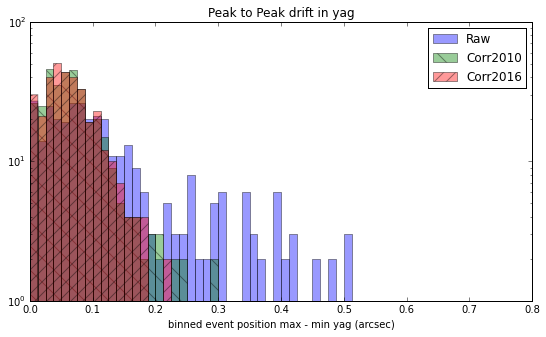

In [17]:
figure(figsize(9,5))
bins = np.arange(0, 0.8, 0.0125)
hist(per_obs['p2p_{}'.format(AX)], bins=bins, color='blue', alpha=.4, hatch='', log=True, label='Raw');
hist(per_obs['p2p_2010_model_resid'], bins=bins, color='green', alpha=.4, hatch='\\', log=True, label='Corr2010');
hist(per_obs['p2p_new_model_resid'], bins=bins, color='red', alpha=.4, hatch='//', log=True, label='Corr2016');
title('Peak to Peak drift in {}'.format(AX));
xlabel('binned event position max - min {} (arcsec)'.format(AX))
legend();

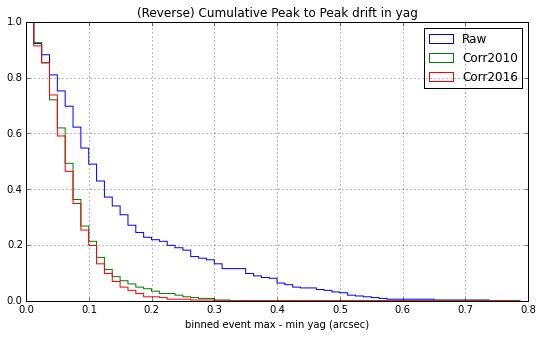

In [18]:
figure(figsize(9,5))
bins = np.arange(0, 0.8, 0.0125)
p2p_hist = hist(per_obs['p2p_{}'.format(AX)], bins=bins, color='blue', histtype='step', cumulative=-1, normed=True, label='Raw');
p2p_2010_hist = hist(per_obs['p2p_2010_model_resid'], bins=bins, color='green', histtype='step', cumulative=-1, 
                     normed=True, label='Corr2010');
p2p_new_hist = hist(per_obs['p2p_new_model_resid'], bins=bins, color='red', histtype='step', cumulative=-1,
                    normed=True, label='Corr2016');
grid()
ylim(0, 1.0)
title('(Reverse) Cumulative Peak to Peak drift in {}'.format(AX));
xlabel('binned event max - min {} (arcsec)'.format(AX))
legend();

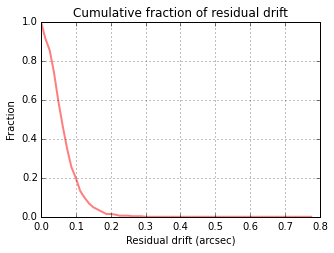

In [19]:
figure(figsize(5, 3.5))
#plot(p2p_hist[1][:-1], p2p_hist[0], label='Raw', alpha=0.5, color='blue', linewidth=2)
#plot(p2p_2010_hist[1][:-1], p2p_2010_hist[0], label='Corr2010')
plot(p2p_new_hist[1][:-1], p2p_new_hist[0], label='Corr2016', color='red', alpha=0.5, linewidth=2)
grid()
ylim(0, 1.0)
title('Cumulative fraction of residual drift');
xlabel('Residual drift (arcsec)')
ylabel('Fraction')

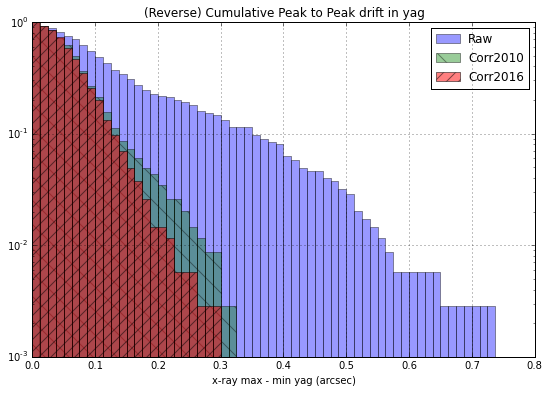

In [20]:
figure(figsize(9,6))
bins = np.arange(0, 0.8, 0.0125)
hist(per_obs['p2p_{}'.format(AX)], bins=bins, color='blue', alpha=.4, log=True, cumulative=-1, normed=True, label='Raw');
hist(per_obs['p2p_2010_model_resid'], bins=bins, color='green', alpha=.4, hatch='\\', log=True, cumulative=-1,
     normed=True, label='Corr2010');
hist(per_obs['p2p_new_model_resid'], bins=bins, color='red', alpha=.5, hatch='//', log=True, cumulative=-1,
     normed=True, label='Corr2016');
grid();
title('(Reverse) Cumulative Peak to Peak drift in {}'.format(AX));
xlabel('x-ray max - min {} (arcsec)'.format(AX))
legend();

In [21]:
# borrow percentile group/select from aimpoint_mon code
per_obs['year'] = DateTime(per_obs['time']).frac_year
per_obs['time_bin'] = np.trunc(per_obs['year'])
t_bin = per_obs.group_by('time_bin')
i_sorts = t_bin.groups.aggregate(np.argsort)
perc_select = {}
for col in 'p2p_{}'.format(AX), 'p2p_2010_model_resid', 'p2p_new_model_resid':
    for perc in (50, 90, -5):
        rows = []
        for group, i_sort in izip(t_bin.groups, i_sorts[col]):
            if perc < 0:
                for row in group[i_sort[perc:]]:
                    rows.append(row)
            else:
                ii = (int(perc) * (len(group) - 1)) // 100
                rows.append(group[i_sort[ii]])
        perc_select[str(perc) + '_' + col] = Table(rows=rows, names=t_bin.colnames)

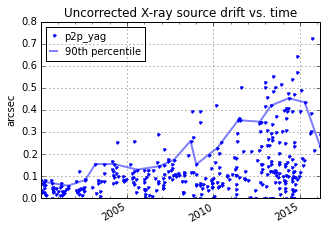

In [22]:
figure(figsize(5, 3.5))
col='p2p_{}'.format(AX)
color='blue'
plot_cxctime(per_obs['time'], per_obs[col], marker='.', color=color, linestyle='', label=col);
plot_cxctime(perc_select['90_' + col]['time'], perc_select['90_' + col][col], color=color,
             label='90th percentile', alpha=.5, linewidth=2)
grid()
title("Uncorrected X-ray source drift vs. time")
ylabel('arcsec')
legend(numpoints=1, loc='upper left', fontsize=10, handlelength=.74)

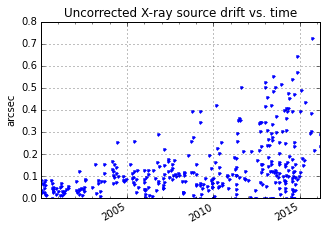

In [23]:
figure(figsize(5, 3.5))
col='p2p_{}'.format(AX)
color='blue'
plot_cxctime(per_obs['time'], per_obs[col], marker='.', color=color, linestyle='', label=col);
#plot_cxctime(perc_select['90_' + col]['time'], perc_select['90_' + col][col], color=color,
#             label='90th percentile', alpha=.5, linewidth=2)
grid()
title("Uncorrected X-ray source drift vs. time")
ylabel('arcsec')
#legend(numpoints=1, loc='upper left', fontsize=10)

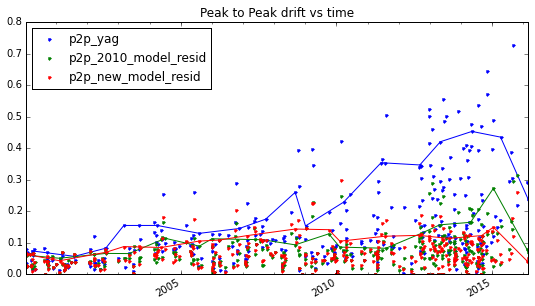

In [24]:
figure(figsize(9, 5))
for col, color in izip(['p2p_{}'.format(AX), 'p2p_2010_model_resid', 'p2p_new_model_resid'], ['b', 'g', 'r']):
    plot_cxctime(per_obs['time'], per_obs[col], marker='.', color=color, linestyle='', label=col);
    plot_cxctime(perc_select['90_' + col]['time'], perc_select['90_' + col][col], color=color)
title("Peak to Peak drift vs time")
legend(numpoints=1, loc='upper left')

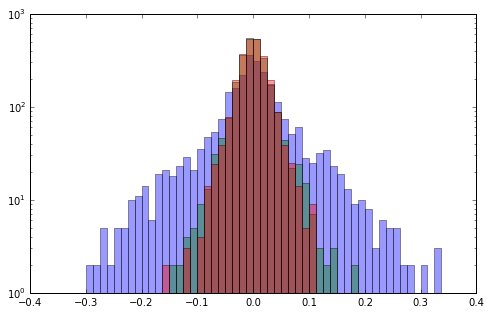

In [25]:
figure(figsize(8, 5))
bins = np.arange(-0.4, 0.4, .0125)
hist(bin_data[AX] - bin_data['{}_mean'.format(AX)], bins=bins, color='blue', alpha=.4, log=True);
hist(bin_data[AX] - bin_data['{}_mean'.format(AX)] - bin_data['2010_model'], bins=bins, log=True, color='green', alpha=.4);
hist(bin_data[AX] - bin_data['{}_mean'.format(AX)] - bin_data['new_model'], bins=bins, log=True, color='red', alpha=.4);


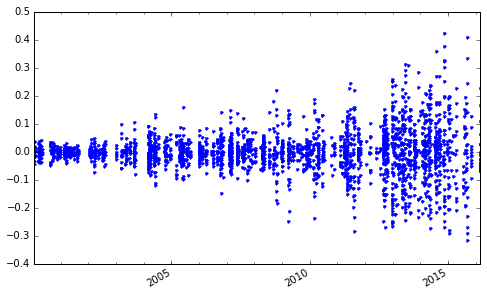

In [26]:
figure()
plot_cxctime(bin_data['time'], bin_data['yag'] - bin_data['yag_mean'], 'b.');

(((matplotlib.dates.YearLocator,
   {'base': 5},
   '%Y',
   matplotlib.dates.YearLocator,
   {'base': 1}),),
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6b54a96e90>)

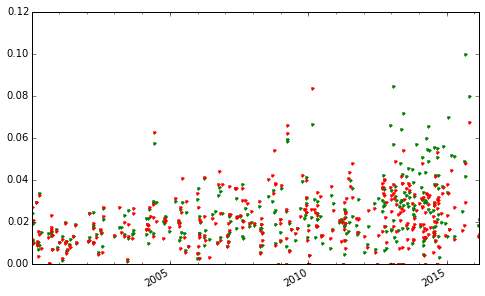

In [27]:
figure()
plot_cxctime(per_obs['time'], per_obs['std_2010_model_resid'], 'g.')
plot_cxctime(per_obs['time'], per_obs['std_new_model_resid'], 'r.')


In [28]:
def resid_plot(obsid):
    src = srcs[srcs['obsid'] == obsid]
    print src[['obsid', 'kalman_datestart', 'detector', 'grating']]
    figure(figsize=(5, 3.5))
    #ax1 = fig.add_axes([0, .33, .75, .75])
    obs_data = bin_data[bin_data['obsid'] == obsid]
    times = (obs_data['time'] - np.min(obs_data['time']))/1000.
    errorbar(times,
             obs_data[AX] - obs_data['{}_mean'.format(AX)],
             yerr=obs_data['{}_std'.format(AX)],
             linestyle='',
            label='X-ray source centroid')
    plot(times, obs_data['2010_model'], color='green')
    plot(times, obs_data['new_model'], color='red', label='Model correction', linewidth=2, alpha=.5)
    grid()
    ylim(-0.5, 0.8)
    xlim(-10, 160)
    title('X-ray drift and model correction')
    xlabel("Time (ksec)")
    ylabel("Offset from mean (arcsec)")
    legend(numpoints=1, fontsize=8)
    #title('Obsid {} {} offsets'.format(obsid, AX))
    #title('Obsid {} {} offsets\n2010 model(green), testing model(red)'.format(obsid, AX))
    #ylabel('{} offset from mean event position (arcsec)'.format(AX))
    #resid = (obs_data[AX] - obs_data['{}_mean'.format(AX)]) - obs_data['new_model']
    #ax2 = fig.add_axes([0, 0, .75, .33], sharex=ax1)
    #plot(times, resid, color='red')
    #ylabel('bin data - model')
    #xlabel('Observation time (ksec)')
    #grid()
    #xlim(-10, 150);
    #ylim(-.4, .4);
    #plt.setp(ax1.get_xticklabels(), visible=False);
    #plt.setp(ax1.get_yticklabels()[0], visible=False);


obsid    kalman_datestart   detector grating
----- --------------------- -------- -------
12916 2011:169:06:06:34.405    HRC-S    LETG


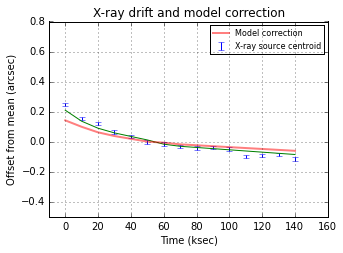

In [29]:
#for obsid in [4820, 14457, 17105, 17128, 12916, 14534, 16313, 16311]:
#    resid_plot(obsid)
resid_plot(12916)


obsid    kalman_datestart   detector grating
----- --------------------- -------- -------
15041 2013:208:01:38:25.039   ACIS-S    NONE


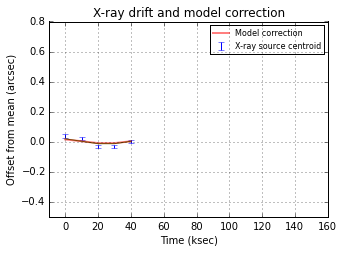

In [30]:
resid_plot(15041)

obsid    kalman_datestart   detector grating
----- --------------------- -------- -------
17128 2015:247:12:26:10.425   ACIS-S    NONE


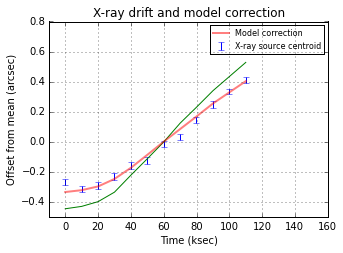

In [31]:
resid_plot(17128)